In [1]:
import bats
import torch 
import numpy as np
import matplotlib.pyplot as plt
import time
from tqdm import tqdm
from scipy.spatial.distance import directed_hausdorff
from torch_tda.nn import RipsLayer, Rips0Layer, BottleneckLayer, WassersteinLayer, BarcodePolyFeature
from torch_tda.nn import BottleneckLayerHera # torch-tda now support it
# from herabottleneck import BottleneckLayerHera
import torch.nn as nn
from torch.nn.utils.parametrizations import orthogonal
import scipy.sparse.linalg as sla
from sklearn.decomposition import PCA # for PCA analysis

In [2]:
def generate_circle(n = 100, p = 4, ind_x=0, ind_y=1, rad = 1, sigma = 0.05):
    # ind_x: the index of dimension where x-axis of cycle lies in
    # ind_y: the index of dimension where y-axis of cycle lies in
    
    thetas = np.arange(0, n) * 2 * np.pi / n
    rs = rad * np.ones(n)
    X = np.hstack((sigma*np.random.randn(n, ind_x),
                   (rs * np.cos(thetas)).reshape(-1,1) + 1,
                   sigma*np.random.randn(n, ind_y - ind_x - 1),
                   (rs * np.sin(thetas)).reshape(-1,1) + 1,
                   sigma*np.random.randn(n, p - ind_y -1)))
    
    return X

def generate_X(n_pt_cirlce, p):
#     p  : dimension of whole space
#     n_pt_cirlce : number of points in each circle
    X = generate_circle(n_pt_cirlce, p, 0, 1)
    labels = np.ones(len(X))
    k = 1
    for i in range(p):
        for j in range(i+1,p):
            if (i,j) != (0,1):
                X = np.vstack((X, generate_circle(n_pt_cirlce, p, i, j) ))
                labels = np.hstack((labels, np.ones(n_pt_cirlce) + k))
                k+=1
    return X, labels

np.random.seed(3)
X, labels = generate_X(50, 5)
X.shape

(500, 5)

Intall d2l first by `pip install -U d2l`

In [17]:
from d2l import torch as d2l
from IPython import display
class Animator:  #@save
    """For plotting data in animation."""
    def __init__(self, xlabel=None, ylabel=None, legend=None, xlim=None,
                 ylim=None, xscale='linear', yscale='linear', nrows=1, ncols=1,
                 figsize=(3.5, 2.5)):
        # Incrementally plot multiple lines
        if legend is None:
            legend = []
        d2l.use_svg_display()
        self.fig, self.axes = d2l.plt.subplots(nrows, ncols, figsize=figsize)
        if nrows * ncols == 1:
            self.axes = [self.axes, ]
        # Use a lambda function to capture arguments
        self.config_axes = lambda: d2l.set_axes(
            self.axes[0], xlabel, ylabel, xlim, ylim, xscale, yscale, legend)

    def add(self, x, y, lr, fmt = '-'):
        self.axes[0].cla() # clear current axes
        self.axes[0].plot(x, y, fmt) # plot
        self.axes[0].legend([lr])
        self.config_axes()
        display.display(self.fig)
        display.clear_output(wait=True)
        # time.sleep(0.5)

In [25]:
import bats
import torch 
import numpy as np
import matplotlib.pyplot as plt
import time
from tqdm import tqdm
from scipy.spatial.distance import directed_hausdorff
from torch_tda.nn import RipsLayer, Rips0Layer, BottleneckLayer, WassersteinLayer, BarcodePolyFeature
from torch_tda.nn import BottleneckLayerHera # torch-tda now support it
# from herabottleneck import BottleneckLayerHera
import torch.nn as nn
from torch.nn.utils.parametrizations import orthogonal
import scipy.sparse.linalg as sla
from sklearn.decomposition import PCA # for PCA analysis

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

def bottleneck_proj_pursuit(X, dim=2, opt_dim=10, optimizer_iter = 10, scheduler_iter = 10, 
flags = (bats.standard_reduction_flag(),bats.clearing_flag()),
degree = +1,
PCA = False,
pca_weight = 0.5,
ortho = True,
optimizer_ = 'SGD', 
metric = 'euclidean', 
sparse = False,             
print_info = False, *args, **kwargs):
    """
    projection pursuit to minimize bottleneck distance
    
    inputs:
    --------
    X: input dataset
    dim: reduction target dimension (default 2)
    opt_dim: optimization on PH dimension 0 for H1; 1 for H1; and 10 for H1 and H0
    optimizer_iter: number of iterations for optimizer 
    scheduler_iter: number of iterations for scheduler (exponential decay for learning rate) 
    flags: BATs reduction flags used to compute PH 
        (do not use bats.extra_reduction_flag() which is bad for opt)
    ortho: If true, we will use `from torch.nn.utils.parametrizations import orthogonal`
    optimizer_: SGD or Adam(still problematic)
    PCA: True if you want to add a PCA penalty variance with weight `pca_weight`
    sparse: True is use sparse Rips construction
    metric: supports various options of metric in BATs: L1, euclidean, etc..
    initial_weights: initial weights/projection matrix, e.g. from PCA
    
    returns:
    -----------
    projection matrix P
    optimization information opt_info
    """

    X = np.array(X, order = 'c') # necessary!!! If your data is not stored in C style
    n, p = X.shape

    linear_layer = nn.Linear(p, dim, bias=False, dtype=torch.double)
    
    # initial weights/projection matrix, e.g. from PCA
    initial_weights = kwargs.get('initial_weights', None)
    if initial_weights != None:
        linear_layer.weight = nn.Parameter(initial_weights)

    if ortho:
        model_lin = orthogonal(linear_layer)
    else: 
        model_lin = linear_layer
    
    if sparse:
        layer = RipsLayer(maxdim=1, sparse = True, eps = 0.5,
                      reduction_flags=flags)
    else:
        if opt_dim == 0:
            layer = Rips0Layer()
        else:
            layer = RipsLayer(maxdim=1, degree = degree, metric = metric, 
                              reduction_flags=flags)

    Xt = torch.tensor(X, dtype=torch.double)
    ground_truth_dgm = layer(Xt)

    # featfn = BarcodePolyFeature(0, 2,0)
    # gt_feat = featfn(ground_truth_dgm)

    # crit = BottleneckLayer()
    crit = BottleneckLayerHera()

    if optimizer_ == 'SGD':
        optimizer = torch.optim.SGD(model_lin.parameters(), lr=1e-3)
        scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.5)
    if optimizer_ == 'Adam':
        optimizer = torch.optim.Adam(model_lin.parameters(), lr = 1e-4)

    losses = []
    bd = 0
    lrs = [] # learning rates
    bd0, bd1 = torch.zeros(1), torch.zeros(1)
    animator = Animator(xlabel='iteration', xlim=[1, scheduler_iter*optimizer_iter+1], ylabel = 'loss')
    
    for i in range(scheduler_iter):
        for j in range(optimizer_iter):
            try:
                ts = []
                t0_total = time.monotonic()
                optimizer.zero_grad()

                XVt = model_lin(Xt)
                Y_dgm = layer(XVt)
                if opt_dim == 10: # dim 0 and 1
                    bd0 = crit(Y_dgm[0], ground_truth_dgm[0])
                    bd1 = crit(Y_dgm[1], ground_truth_dgm[1])
                    loss = bd0 + bd1
                    bd = max(bd0.detach().numpy(), bd1.detach().numpy())

                if opt_dim == 1: # only dim 1
                    bd1 = crit(Y_dgm[1], ground_truth_dgm[1])
                    loss = bd1
                    bd = bd1.detach().numpy()

                if opt_dim == 0: # only dim 0
                    bd0 = crit(Y_dgm[0], ground_truth_dgm[0])
                    loss = bd0
                    bd = bd0.detach().numpy()

                if PCA:
                    pca_layer = PCA_layer()
                    pca_loss = pca_layer(XVt)
                    loss -= pca_weight * pca_loss # '-': PCA layer is maximizing 

                loss.backward()
                optimizer.step()

                if PCA:
                    losses.append([loss.detach().numpy() + pca_weight * pca_loss.detach().numpy(), 
                    - pca_loss.detach().numpy()])
                else:
                    losses.append(loss.detach().numpy())

                # plot
                animator.add(np.arange(j + optimizer_iter * i+1), np.array(losses), f'lr = {(get_lr(optimizer)):.1e}')

                t1_total = time.monotonic()

                if print_info:
                    print(f'iter  {j + optimizer_iter * i}/{scheduler_iter * optimizer_iter},\t loss = {loss:.3f}, \t time = {(t1_total - t0_total):.3f}, lr = {(get_lr(optimizer)):.1e}')
            
            # stop at any time as you want
            except KeyboardInterrupt:
                opt_info = {'bd0': bd0, 'bd1':bd1, 'losses': losses, 'lrs': lrs, 'X_dr': XVt.detach().numpy()}
                return model_lin.weight.detach().numpy(), opt_info
            
        # schedule learning rate if using SGD
        if optimizer_ == 'SGD':
            scheduler.step()
            # lrs.append(scheduler.get_last_lr())
            
            
    opt_info = {'bd0': bd0, 'bd1':bd1, 'losses': losses, 'lrs': lrs, 'X_dr': XVt.detach().numpy()}
    return model_lin.weight.detach().numpy(), opt_info


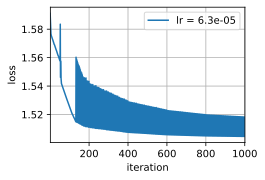

In [30]:
from PH_projection_pursuit import subsample_bats
np.random.seed(4)
X, labels = generate_X(50, 5)
Y, indsY, dHY = subsample_bats(X, k = 100)
P, opt_info = bottleneck_proj_pursuit(Y, scheduler_iter = 5, opt_dim=1, optimizer_ = 'SGD',
                                      optimizer_iter = 200, print_info=False)

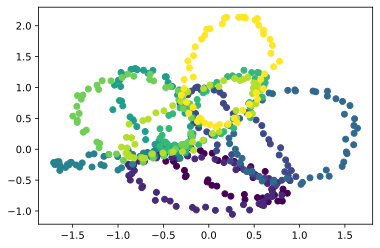

In [31]:
X_PH = X @ P.T
plt.scatter(X_PH[:,0], X_PH[:,1], c = labels)